In [1]:
#JV

In [292]:
#JV

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
import random
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties

from tqdm.notebook import tqdm

#!python3 -m pip install wandb
import wandb

import argparse

from Core_Utils import *

from Encoder_Decoder_Architecture import *

from Machine_Translator import *

seed = 23

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

0       18
1       58
2       38
3       22
4       38
        ..
4091    22
4092    42
4093    26
4094    38
4095    26
Name: Target Word, Length: 4096, dtype: int64

In [53]:
#df['Predicted Word'][:df['Target Word'].str.len().astype(int)+1]
df['Predicted Word'] = df.apply(lambda row: row['Predicted Word'][:len(row['Target Word'])], axis=1) + "]"

In [60]:
df.to_csv("Final_Results_Vanilla.csv",index = False)

In [61]:
df1 = pd.read_csv("Results_Attention.csv")
df2 = pd.read_csv("Predictions_Vanilla.csv")

In [65]:
tmp1 = df1[df1['Is Prediction Correct']==1]
tmp2 = df2[df2['Is Prediction Correct']==0]

In [68]:
set(tmp1['Source Word'].to_list()).intersection(set(tmp2['Source Word'].to_list()))

{"['a' 'a' 'd' 'h' 'a' 'r' 'a' 'm' 't' 'o' 'e']",
 "['a' 'a' 'h' 'a' 'r' 'a' 'm' 'u' 'g' 'a' 'a']",
 "['a' 'a' 'j' 'a' 'a' 'd' 'h']",
 "['a' 'a' 'm' 'o' 'd' 'h' 'i' 'n' 'c' 'h' 'i' 'n' 'a']",
 "['a' 'a' 'n' 'd' 'h' 'r' 'a' 's' 'a' 'r' 'a' 's' 'v' 'a' 't' 'i']",
 "['a' 'a' 'v' 'a' 'g' 'i' 'm' 'j' 'a' 'm' 't' 'a']",
 "['a' 'a' 'y' 'u' 's' 's' 'h' 'u']",
 "['a' 'a' 'z' 'a' 'a' 'd' 'h']",
 "['a' 'e' 'm' 'a' 'a' 't' 'h' 'r' 'a' 'm']",
 "['a' 'e' 'n' 'u' 'g' 'u' 'l' 'u']",
 "['a' 'e' 'n' 'u' 'g' 'u' 'n' 'u']",
 "['a' 'e' 'n' 'u' 'g' 'u']",
 "['a' 'e' 'r' 'p' 'a' 'd' 'a' 'k' 'a']",
 "['a' 'g' 'a' 'k' 'u' 'n' 'd' 'a']",
 "['a' 'g' 'n' 'i' 'n' 'i']",
 "['a' 'h' 'm' 'a' 'd' 'n' 'a' 'g' 'a' 'r']",
 "['a' 'l' 'a' 'y' 'a' 'm' 'l' 'o']",
 "['a' 'l' 'w' 'a' 'd' 'h' 'i']",
 "['a' 'm' 'a' 'r' 'a' 'v' 'a' 't' 'i']",
 "['a' 'm' 'e' 'r' 'i' 'c' 'a' 'n']",
 "['a' 'm' 'e' 'r' 'i' 'k' 'a' 'n']",
 "['a' 'n' 'i' 'v' 'a' 'a' 'r' 'y' 'a' 'm' 'y' 'n' 'a']",
 "['a' 'n' 'n' 'a' 'p' 'o' 'l' 'i' 's']",
 "['a' 'n' 'n'

In [150]:
def parse(sw):
    att_pred = df1[df1['Source Word']==sw]['Predicted Word'].to_list()[0]
    norm_pred = df2[df2['Source Word']==sw]['Predicted Word'].to_list()[0]

    
    clean_src = sw.replace('[',"").replace(']','').replace("'","").replace("\n","").replace(" ","")
    clean_att_pred = att_pred.replace('[',"").replace(']','').replace("'","").replace("\n","").replace(" ","")
    clean_norm_pred = norm_pred.replace('[',"").replace(']','').replace("'","").replace("\n","").replace(" ","")

    return clean_src,clean_att_pred,clean_norm_pred

In [151]:
sw = "['c' 'h' 'o' 'o' 'd' 'a' 'k' 'o' 'o' 'd' 'a' 'd' 'a' 'n' 'u' 'k' 'u' 'n'\n 't' 'u' 'n' 'n' 'a' 'd' 'i']"
parse(sw)

('choodakoodadanukuntunnadi', 'చూడకూడదనుకుంటున్నది', 'చూడకూడననుకుంటున్నది')

In [152]:
sw = "['t' 'a' 'p' 'p' 'i' 'n' 'c' 'h' 'u' 'k' 'o' 'v' 'a' 'd' 'a' 'm' 'l' 'o'\n 'n' 'o' 'o']"
parse(sw)

('tappinchukovadamlonoo', 'తప్పించుకోవడంలోనూ', 'తప్పించుకోవడంలోనో')

In [153]:
sw = "['p' 'r' 'a' 'd' 'a' 'r' 's' 'h' 'i' 'n' 'c' 'h' 'e' 't' 'a' 't' 'u' 'v'\n 'a' 'n' 't' 'i']"
parse(sw)

('pradarshinchetatuvanti', 'ప్రదర్శించేటటువంటి', 'ప్రదర్శించేతతువంటి')

In [154]:
sw = "['m' 'a' 'h' 'a' 'a' 'k' 'o' 'o' 't' 'a' 'm' 'i' 'l' 'o']"
parse(sw)

('mahaakootamilo', 'మహాకూటమిలో', 'మహాకూతమిలో')

In [155]:
sw = "['u' 'd' 'i' 'k' 'i' 'n' 'c' 'h' 'i' 'n' 'a']"
parse(sw)

('udikinchina', 'ఉడికించిన', 'ఉదికించిన')

In [156]:
sw = "['r' 'a' 'm' 'a' 'n']"
parse(sw)

('raman', 'రామన్', 'రమమన్')

In [157]:
sw = "['v' 'e' 't' 'a' 'n' 'a' 'm']"
parse(sw)

('vetanam', 'వేతనం', 'వేతాన')

In [158]:
sw = "['y' 'e' 'n' 'u' 'g' 'u' 'l' 'u']"
parse(sw)

('yenugulu', 'ఏనుగులు', 'యెనుగుల')

In [159]:
sw = "['g' 'i' 'g' 'a' 'a' 'h' 'e' 't' 'j']"
parse(sw)

('gigaahetj', 'గిగాహెట్జ్', 'గిగాహేట్జ్')

In [160]:
sw = "['z' 'y' 'd' 'u' 's']"
parse(sw)

('zydus', 'జైడస్', 'జిడస్')

In [148]:
intresting_data = [['choodakoodadanukuntunnadi','చూడకూడదనుకుంటున్నది',19],['tappinchukovadamlonoo','తప్పించుకోవడంలోనూ',17],['pradarshinchetatuvanti','ప్రదర్శించేటటువంటి',18],['mahaakootamilo','మహాకూటమిలో',10],['udikinchina','ఉడికించిన',9],['raman','రామన్',5],['vetanam',"వేతనం",5],['yenugulu','ఏనుగులు',7],['gigaahetj','గిగాహెట్జ్',10],['zydus','జైడస్',5]]

In [161]:
intresting_data

[['choodakoodadanukuntunnadi', 'చూడకూడదనుకుంటున్నది', 19],
 ['tappinchukovadamlonoo', 'తప్పించుకోవడంలోనూ', 17],
 ['pradarshinchetatuvanti', 'ప్రదర్శించేటటువంటి', 18],
 ['mahaakootamilo', 'మహాకూటమిలో', 10],
 ['udikinchina', 'ఉడికించిన', 9],
 ['raman', 'రామన్', 5],
 ['vetanam', 'వేతనం', 5],
 ['yenugulu', 'ఏనుగులు', 7],
 ['gigaahetj', 'గిగాహెట్జ్', 10],
 ['zydus', 'జైడస్', 5]]

In [165]:
heatmap_df = pd.DataFrame(intresting_data)

In [168]:
heatmap_df = heatmap_df.drop(2,axis=1)

,0,1,2
0,choodakoodadanukuntunnadi,చూడకూడదనుకుంటున్నది,19
1,tappinchukovadamlonoo,తప్పించుకోవడంలోనూ,17
2,pradarshinchetatuvanti,ప్రదర్శించేటటువంటి,18
3,mahaakootamilo,మహాకూటమిలో,10
4,udikinchina,ఉడికించిన,9
5,raman,రామన్,5
6,vetanam,వేతనం,5
7,yenugulu,ఏనుగులు,7
8,gigaahetj,గిగాహెట్జ్,10
9,zydus,జైడస్,5


In [169]:
heatmap_df.to_csv("tel_heatmap.csv",index=False)

In [172]:
from Core_Utils import *
from Machine_Translator import *
from Encoder_Decoder_Architecture import *

In [217]:
config = {

        'batch_size':512,

        'bidirectional' :  True,

        'dropout' : 0.1,

        'embedding_size':256,

        'epochs' : 20,

        'hidden_size':512,

        'lr':  3e-4,

        'num_layers' : 3,

        'optimiser': "rmsprop",

        'rnn_type' : "gru",

        'teacher_forcing_ratio' : 0.4,

        'weight_decay': 1e-5,
        'use_attention' : True,

        'device' : None
}



In [218]:
batch_size = config['batch_size']
target_lang = "tel"

base_dir = "aksharantar_sampled/"

if config['device'] == None:
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("mps")
else:
    device = torch.device("mps")

use_meta_tokens = True

lang_dir = base_dir + target_lang + "/"

##creating train loader
train_lp = LanguageProcessor(language_directory=lang_dir,target_lang_name=target_lang,mode="train",meta_tokens=use_meta_tokens)
## the ids of these tokens are the same in the source and target language
pad_token_id = train_lp.source_char2id['<pad>']

collate_fn_ptr = partial(collate_fn,pad_token_id=pad_token_id,device=device)

train_dataset = WordDataset(train_lp,device=device)
train_loader = DataLoader(train_dataset, batch_size=batch_size,collate_fn=collate_fn_ptr, shuffle=True)

## creating test loader
test_lp = LanguageProcessor(language_directory=lang_dir,target_lang_name=target_lang,mode="test",meta_tokens=use_meta_tokens)

## to make sure that the same vocabulary and dictionaries are used everywhere
test_lp.source_char2id = train_lp.source_char2id
test_lp.source_id2char = train_lp.source_id2char
test_lp.target_char2id = train_lp.target_char2id
test_lp.target_id2char = train_lp.target_id2char

test_dataset = WordDataset(test_lp,device=device)
test_loader = DataLoader(test_dataset, batch_size=batch_size,collate_fn=collate_fn_ptr, shuffle=False)

## creating validation loader
valid_lp = LanguageProcessor(language_directory=lang_dir,target_lang_name=target_lang,mode="valid",meta_tokens=use_meta_tokens)
valid_lp.source_char2id = train_lp.source_char2id
valid_lp.source_id2char = train_lp.source_id2char
valid_lp.target_char2id = train_lp.target_char2id
valid_lp.target_id2char = train_lp.target_id2char

valid_dataset = WordDataset(valid_lp,device=device)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size,collate_fn=collate_fn_ptr, shuffle=True)


##in principle these are all fixed across train/test/valid data
 
source_vocab_size = len(list(train_lp.source_char2id.keys()))
target_vocab_size = len(list(train_lp.target_char2id.keys()))

hidden_size = config['hidden_size']
embedding_size = hidden_size

epochs = config['epochs']

optimiser = config['optimiser']

weight_decay = config['weight_decay']

lr = config['lr']

num_layers = config['num_layers']

## Allowed Values : "GRU"/"RNN"/"LSTM" (not case sensitive)
rnn_type = config['rnn_type'].upper()

bidirectional = config['bidirectional']
teacher_forcing_ratio = config['teacher_forcing_ratio']

dropout=config['dropout']

use_attention = config['use_attention']

model = MachineTranslator(source_vocab_size,target_vocab_size,hidden_size,embedding_size,rnn_type,batch_size,pad_token_id,dropout,num_layers,bidirectional,use_attention,device)

model.train(train_loader,valid_loader,model.encoder, model.decoder, epochs,padding_idx = pad_token_id,optimiser = optimiser,weight_decay=weight_decay, lr=lr,teacher_forcing_ratio = teacher_forcing_ratio,device=device,wandb_logging = False)

loss_criterion = nn.CrossEntropyLoss(ignore_index = pad_token_id).to(device)
test_loss,_,test_accuracy = model.compute_accuracy(test_loader,model.encoder,model.decoder,loss_criterion,ignore_padding=True,device=device,save_results=True,filename = "predictions_attention")
print(f"Testing Loss : {test_loss}\tTesting Accuracy : {test_accuracy}%")

  5%|██████▏                                                                                                                     | 1/20 [03:23<1:04:33, 203.86s/it]

Epoch 1	 Train Loss : 2.7698	 Train Acc : 0.92% 	 Val Loss : 0.0042	 Val Acc : 0.37%



 10%|████████████▌                                                                                                                 | 2/20 [05:38<49:00, 163.36s/it]

Epoch 2	 Train Loss : 1.8963	 Train Acc : 1.22% 	 Val Loss : 0.0034	 Val Acc : 3.08%



 15%|██████████████████▉                                                                                                           | 3/20 [07:54<42:43, 150.79s/it]

Epoch 3	 Train Loss : 1.3828	 Train Acc : 4.91% 	 Val Loss : 0.0025	 Val Acc : 17.09%



 20%|█████████████████████████▏                                                                                                    | 4/20 [10:15<39:09, 146.85s/it]

Epoch 4	 Train Loss : 0.9566	 Train Acc : 16.73% 	 Val Loss : 0.0023	 Val Acc : 24.15%



 25%|███████████████████████████████▌                                                                                              | 5/20 [12:30<35:36, 142.46s/it]

Epoch 5	 Train Loss : 0.6829	 Train Acc : 30.55% 	 Val Loss : 0.0019	 Val Acc : 35.55%



 30%|█████████████████████████████████████▊                                                                                        | 6/20 [14:44<32:37, 139.79s/it]

Epoch 6	 Train Loss : 0.4678	 Train Acc : 44.37% 	 Val Loss : 0.0016	 Val Acc : 42.19%



 35%|████████████████████████████████████████████                                                                                  | 7/20 [16:59<29:54, 138.04s/it]

Epoch 7	 Train Loss : 0.4333	 Train Acc : 50.46% 	 Val Loss : 0.0013	 Val Acc : 50.1%



 40%|██████████████████████████████████████████████████▍                                                                           | 8/20 [19:13<27:23, 136.96s/it]

Epoch 8	 Train Loss : 0.3589	 Train Acc : 55.78% 	 Val Loss : 0.0013	 Val Acc : 53.69%



 45%|████████████████████████████████████████████████████████▋                                                                     | 9/20 [21:28<24:59, 136.29s/it]

Epoch 9	 Train Loss : 0.287	 Train Acc : 60.96% 	 Val Loss : 0.0012	 Val Acc : 51.86%



 50%|██████████████████████████████████████████████████████████████▌                                                              | 10/20 [23:43<22:38, 135.89s/it]

Epoch 10	 Train Loss : 0.3375	 Train Acc : 60.38% 	 Val Loss : 0.0012	 Val Acc : 55.4%



 55%|████████████████████████████████████████████████████████████████████▊                                                        | 11/20 [25:57<20:18, 135.40s/it]

Epoch 11	 Train Loss : 0.2368	 Train Acc : 66.5% 	 Val Loss : 0.0012	 Val Acc : 56.64%



 60%|███████████████████████████████████████████████████████████████████████████                                                  | 12/20 [28:12<18:02, 135.25s/it]

Epoch 12	 Train Loss : 0.1758	 Train Acc : 71.51% 	 Val Loss : 0.0012	 Val Acc : 56.86%



 65%|█████████████████████████████████████████████████████████████████████████████████▎                                           | 13/20 [30:27<15:46, 135.15s/it]

Epoch 13	 Train Loss : 0.2288	 Train Acc : 69.74% 	 Val Loss : 0.0012	 Val Acc : 57.91%



 70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 14/20 [32:42<13:30, 135.12s/it]

Epoch 14	 Train Loss : 0.1455	 Train Acc : 75.55% 	 Val Loss : 0.0012	 Val Acc : 57.71%



 75%|█████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15/20 [34:57<11:15, 135.05s/it]

Epoch 15	 Train Loss : 0.2302	 Train Acc : 72.58% 	 Val Loss : 0.0012	 Val Acc : 59.57%



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16/20 [37:12<08:59, 134.95s/it]

Epoch 16	 Train Loss : 0.1328	 Train Acc : 79.31% 	 Val Loss : 0.0012	 Val Acc : 57.96%



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17/20 [39:28<06:45, 135.13s/it]

Epoch 17	 Train Loss : 0.1108	 Train Acc : 79.94% 	 Val Loss : 0.0012	 Val Acc : 59.91%



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 18/20 [41:43<04:30, 135.22s/it]

Epoch 18	 Train Loss : 0.1688	 Train Acc : 79.11% 	 Val Loss : 0.0012	 Val Acc : 58.91%



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 19/20 [43:58<02:15, 135.08s/it]

Epoch 19	 Train Loss : 0.1351	 Train Acc : 80.86% 	 Val Loss : 0.0012	 Val Acc : 60.64%



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [46:13<00:00, 138.66s/it]

Epoch 20	 Train Loss : 0.0697	 Train Acc : 87.55% 	 Val Loss : 0.0013	 Val Acc : 58.57%


Testing Loss : 0.0015	Testing Accuracy : 55.71%


In [227]:
encoder = model.encoder
decoder = model.decoder

save_results = False
criterion = loss_criterion

char_lvl_accuracy = 0
word_level_accuracy = 0

tot_chars = 0
tot_words = 0

tot_correct_char_preds = 0
tot_correct_word_preds = 0

loss = 0

if save_results:
    rows = []

with torch.no_grad():

    train = 0

    if encoder.training and decoder.training: ## reset the the model back to train mode
        train = 1

    encoder.eval()
    decoder.eval()

    for data in test_loader:
        
        input_tensor, target_tensor,_,target_max_len = data

        batch_size = data[0].shape[0]

        if encoder.rnn_type == "LSTM":
            encoder_hidden = torch.zeros(encoder.num_layers*encoder.D, batch_size, encoder.hidden_size, device=device)
            encoder_cell = torch.zeros(encoder.num_layers*encoder.D, batch_size, encoder.hidden_size, device=device)
        else:
            encoder_hidden = None
            encoder_cell = None
        

        encoder_hidden_contexts, encoder_last_hidden, encoder_cell = encoder(input_tensor,encoder_hidden,encoder_cell)
        ## even though we are passing target tensor, the teacher forcing ratio is 0, so no teacher forcing
        decoder_outputs, _, attentions = decoder(encoder_hidden_contexts, encoder_last_hidden,encoder_cell, target_tensor = target_tensor,teacher_forcing_ratio = 0)
        loss += criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1)).item()

        

        ## For a batch, for each character find the most probable output word.
        multi_step_preds = torch.argmax(decoder_outputs,dim=2)
        multi_step_pred_correctness = (multi_step_preds ==  target_tensor)
        num_chars = multi_step_preds.numel() ##find the total number of characters in the current batch
        num_words = multi_step_preds.shape[0] ##find the total number of words in the current batch.

        if True: ## if padding has to be ignored.

            ## for each word, based on the padding token ID, find the first occurance of the padding token, marking the begining of padding.
            
            ## argmax is not supported for bool on cuda, hence casting it to long.
            padding_start = torch.argmax((target_tensor == test_loader.dataset.pad_token_id).to(torch.long),dim=1).to(device)
            ## Creating a mask with 1's in each position of a padding token
            mask = (torch.arange(target_tensor.size(1)).unsqueeze(0).to(device) >= padding_start.unsqueeze(1))
            #print(mask)
            
            ##doing a logical OR with the mask makes sure that the padding tokens do not affect the correctness of the word
            tot_correct_word_preds += (torch.all(torch.logical_or(multi_step_pred_correctness,mask),dim=1).int().sum()).item()
            tot_words += num_words

            ##creating a complement of the mask so to mark padding tokens as irrelevant
            complement_mask = (1-mask.int()).bool()
            num_pad_chars = mask.int().sum().item()
            ##counting number of non_pad_chars to compute accuracy.
            num_non_pad_chars = num_chars - num_pad_chars

            tot_correct_char_preds += (torch.logical_and(multi_step_pred_correctness,complement_mask).int().sum()).item()
            tot_chars += num_non_pad_chars

            word_preds_correctness = torch.all(torch.logical_or(multi_step_pred_correctness,mask),dim=1).int()
            if save_results:
                word_preds_correctness = torch.all(torch.logical_or(multi_step_pred_correctness,mask),dim=1).int()
                for i in range(multi_step_preds.shape[0]):
                    rows.append([dataloader.dataset.lp.decode_word(input_tensor[i].cpu().numpy(),lang_id=0),dataloader.dataset.lp.decode_word(target_tensor[i].cpu().numpy(),lang_id=1),dataloader.dataset.lp.decode_word(multi_step_preds[i].cpu().numpy(),lang_id=1),word_preds_correctness[i].cpu().item()])
            
            break
        else: ##otherwise.

            tot_correct_word_preds += (torch.all(multi_step_pred_correctness,dim=1).int().sum()).item()
            tot_words += num_words
            
            tot_correct_char_preds += (multi_step_pred_correctness.int().sum()).item()
            tot_chars += num_chars

    #char_lvl_accuracy = round(tot_correct_char_preds*100/tot_chars,2)
    #word_lvl_accuracy = round(tot_correct_word_preds*100/tot_words,2)

    loss /= test_loader.dataset.data.shape[0]

In [228]:
target_tensor.shape

torch.Size([512, 21])

In [229]:
input_tensor.shape

torch.Size([512, 24])

In [230]:
len(attentions),attentions[0].squeeze().shape

(21, torch.Size([512, 24]))

In [231]:
#input_tensor[0].detach().numpy()
sample_inp = test_lp.decode_word(input_tensor[0].detach().cpu().numpy(),0)
sample_out = test_lp.decode_word(target_tensor[0].detach().cpu().numpy(),1)

"".join(list(sample_inp)),"".join(list(sample_out)),attentions[0].squeeze()[0]

('vithananni',
 'విత్తనాన్ని',
 tensor([4.4049e-03, 7.9822e-04, 9.1372e-05, 2.4147e-04, 6.9791e-03, 7.0836e-02,
         2.4450e-01, 2.6100e-01, 1.6102e-01, 1.0261e-01, 3.7232e-02, 1.9096e-02,
         1.2056e-02, 8.4456e-03, 6.7097e-03, 5.8082e-03, 5.2174e-03, 4.7113e-03,
         4.2869e-03, 4.1558e-03, 4.5848e-03, 5.9358e-03, 9.3970e-03, 1.9879e-02],
        device='mps:0'))

In [238]:
"""

target_tensor : 512x21 : Batch Size x Max Target Len

input_tensor : 512x24 : Batch Size x Max Input Len

attentions : List of 21 values, each value is 512x24 : Batch Size x Max Input Len

"""

'\n\ntarget_tensor : 512x21 : Batch Size x Max Target Len\n\ninput_tensor : 512x24 : Batch Size x Max Input Len\n\nattentions : List of 21 values, each value is 512x24 : Batch Size x Max Input Len\n\n'

['choodakoodadanukuntunnadi',
 'tappinchukovadamlonoo',
 'pradarshinchetatuvanti',
 'mahaakootamilo',
 'udikinchina',
 'raman',
 'vetanam',
 'yenugulu',
 'gigaahetj',
 'zydus']

In [295]:
count = 0

attention_heatmap_data = []

for i in range(batch_size):
    if word_preds_correctness[i] and count<10:

        count += 1
        
        sample_inp = test_lp.decode_word(input_tensor[i].detach().cpu().numpy(),0)
        sample_out = test_lp.decode_word(target_tensor[i].detach().cpu().numpy(),1)
        
        max_relevant_step = len(sample_out)
        max_relevant_input = len(sample_inp)

        #print(max_relevant_input)
        
        attention_matrix = [attentions[step].squeeze()[i].detach().cpu().numpy()[:max_relevant_input] for step in range(len(attentions)) if step<max_relevant_step]

        attention_heatmap_data.append([sample_inp,sample_out,np.array(attention_matrix)])
        
        print("".join(list(sample_inp)),"".join(list(sample_out)))#,attentions[0].squeeze()[0]
    

prayaanikulu ప్రయాణికులు
puraanamulanu పురాణములను
union యూనియన్
naats నాట్స్
deshamunaku దేశమునకు
vishveshvarudini విశ్వేశ్వరుడిని
astraalanu అస్త్రాలను
lingamunu లింగమును
linde లిండే
saavadhaanangaa సావధానంగా


In [296]:
for i in range(count):
    print(len(attention_heatmap_data[i][0]),len(attention_heatmap_data[i][1]),attention_heatmap_data[i][2].shape)

12 11 (11, 12)
13 10 (10, 13)
5 7 (7, 5)
5 6 (6, 5)
11 8 (8, 11)
16 15 (15, 16)
10 10 (10, 10)
9 8 (8, 9)
5 5 (5, 5)
15 9 (9, 15)


findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

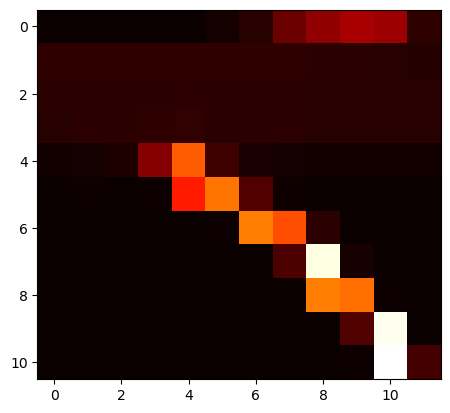

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

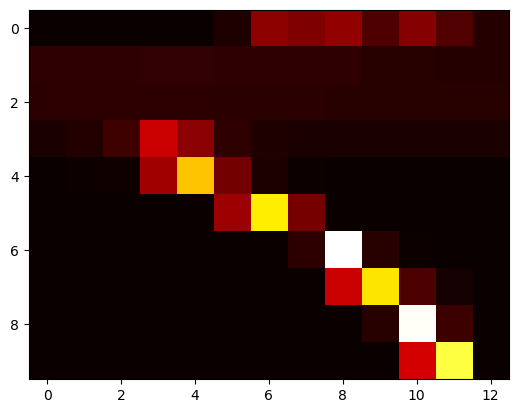

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

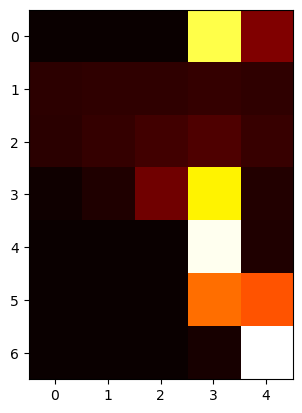

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

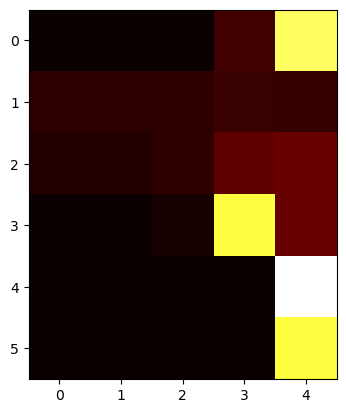

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

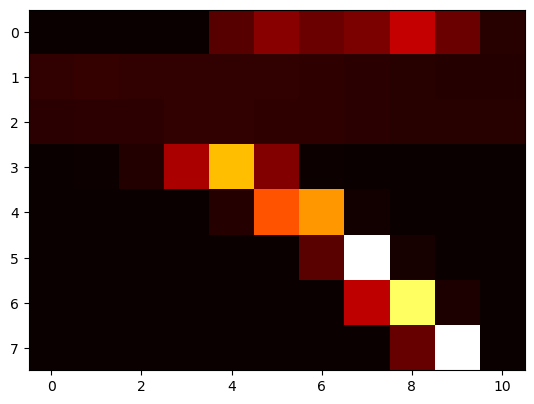

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

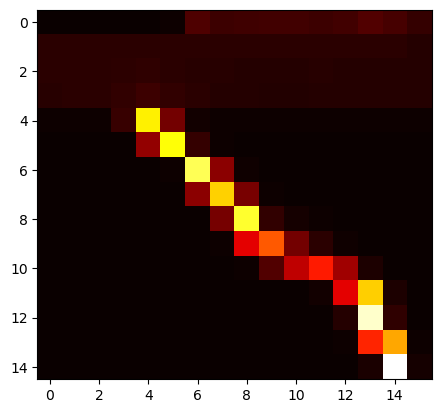

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

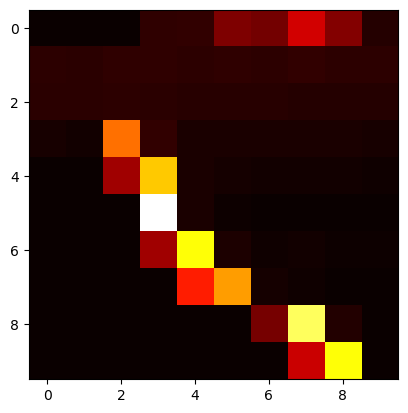

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

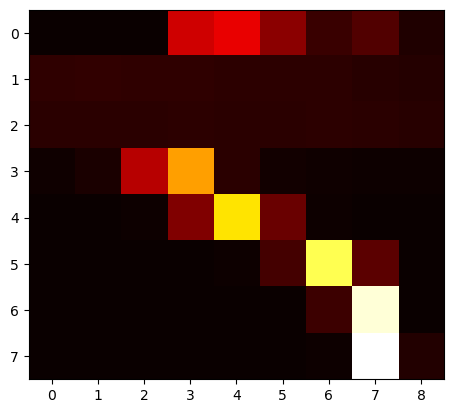

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

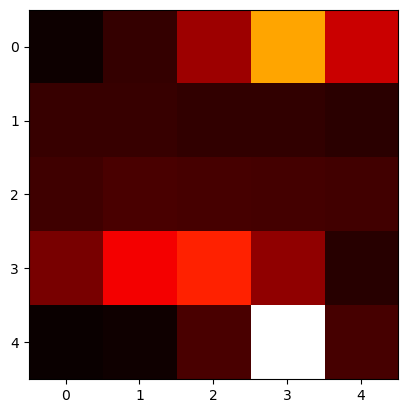

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

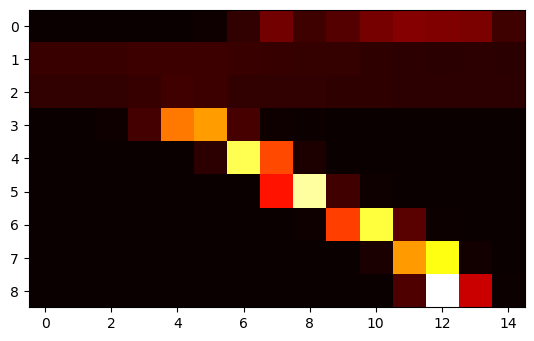

In [304]:
for i in range(count):
    plt.imshow(attention_heatmap_data[i][2], cmap='hot')
    plt.show()

In [309]:
telugu_font = FontProperties(fname = 'Noto_Sans_Telugu/NotoSansTelugu_Condensed-Regular.ttf')

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

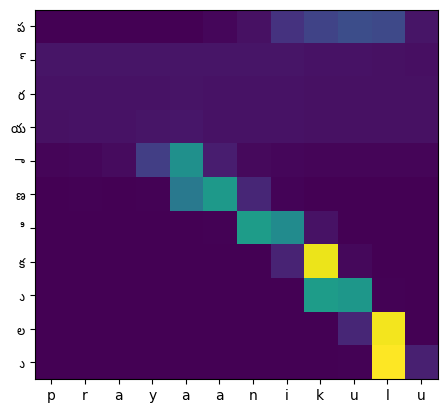

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

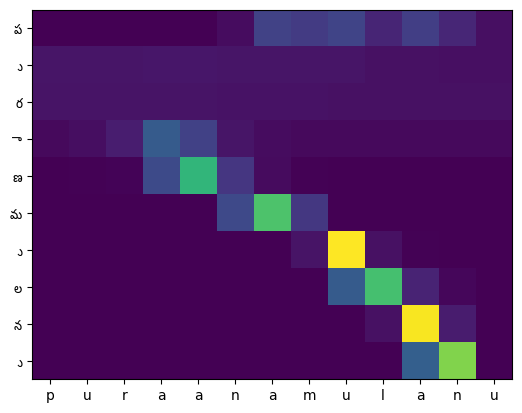

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.


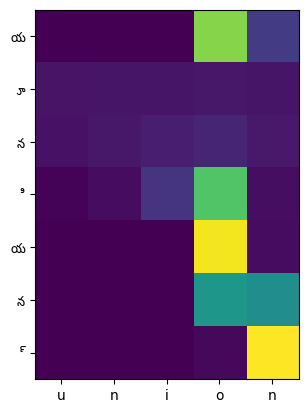

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.


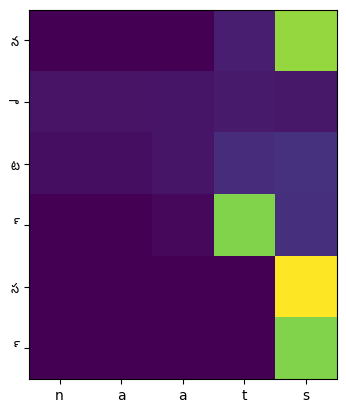

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

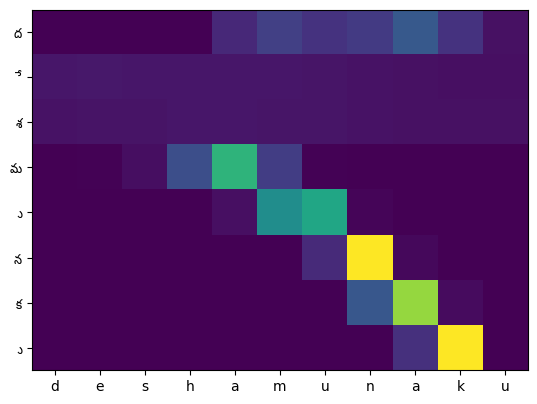

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

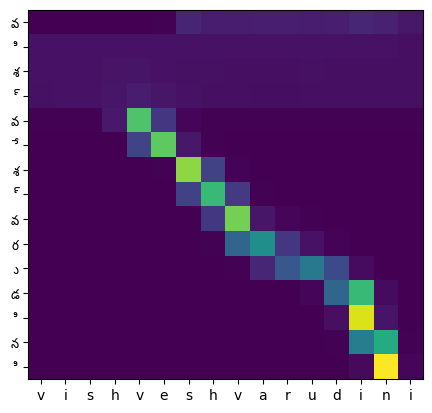

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.


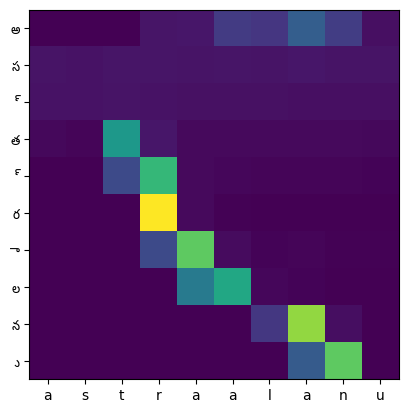

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.


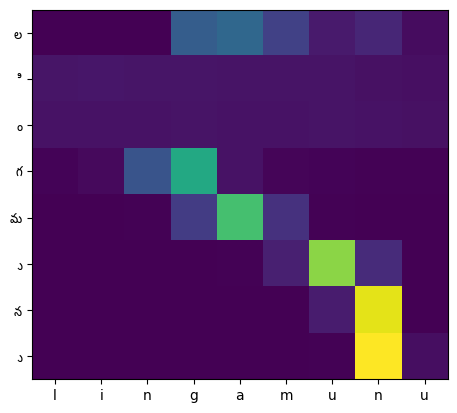

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.


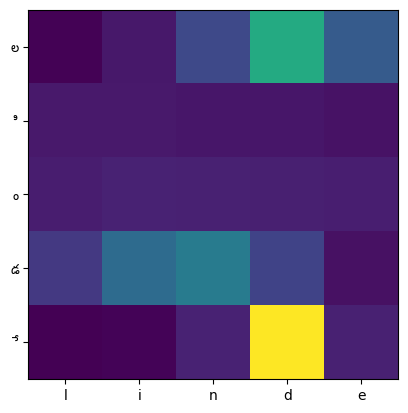

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

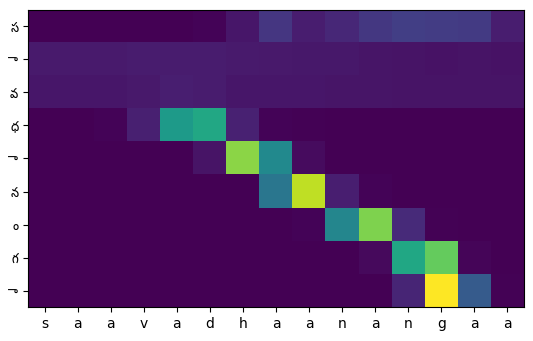

In [312]:
for i in range(count):
    fig, ax = plt.subplots()
    im = ax.imshow(attention_heatmap_data[i][2])
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(attention_heatmap_data[i][0])), labels=attention_heatmap_data[i][0])
    ax.set_yticks(np.arange(len(attention_heatmap_data[i][1])), labels=list(attention_heatmap_data[i][1]), fontproperties=telugu_font)


In [320]:
wandb.login(key="")

wandb: Currently logged in as: cs23m036 (tmajestical). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/tejasmalladi/.netrc


True

In [327]:
wandb.init(project="JV_CS23M036_TEJASVI_DL_ASSIGNMENT3", name="Attention-HeatMaps-Visualization")

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Font family 'Noto Sans Telugu' not found.
findfont: Fo

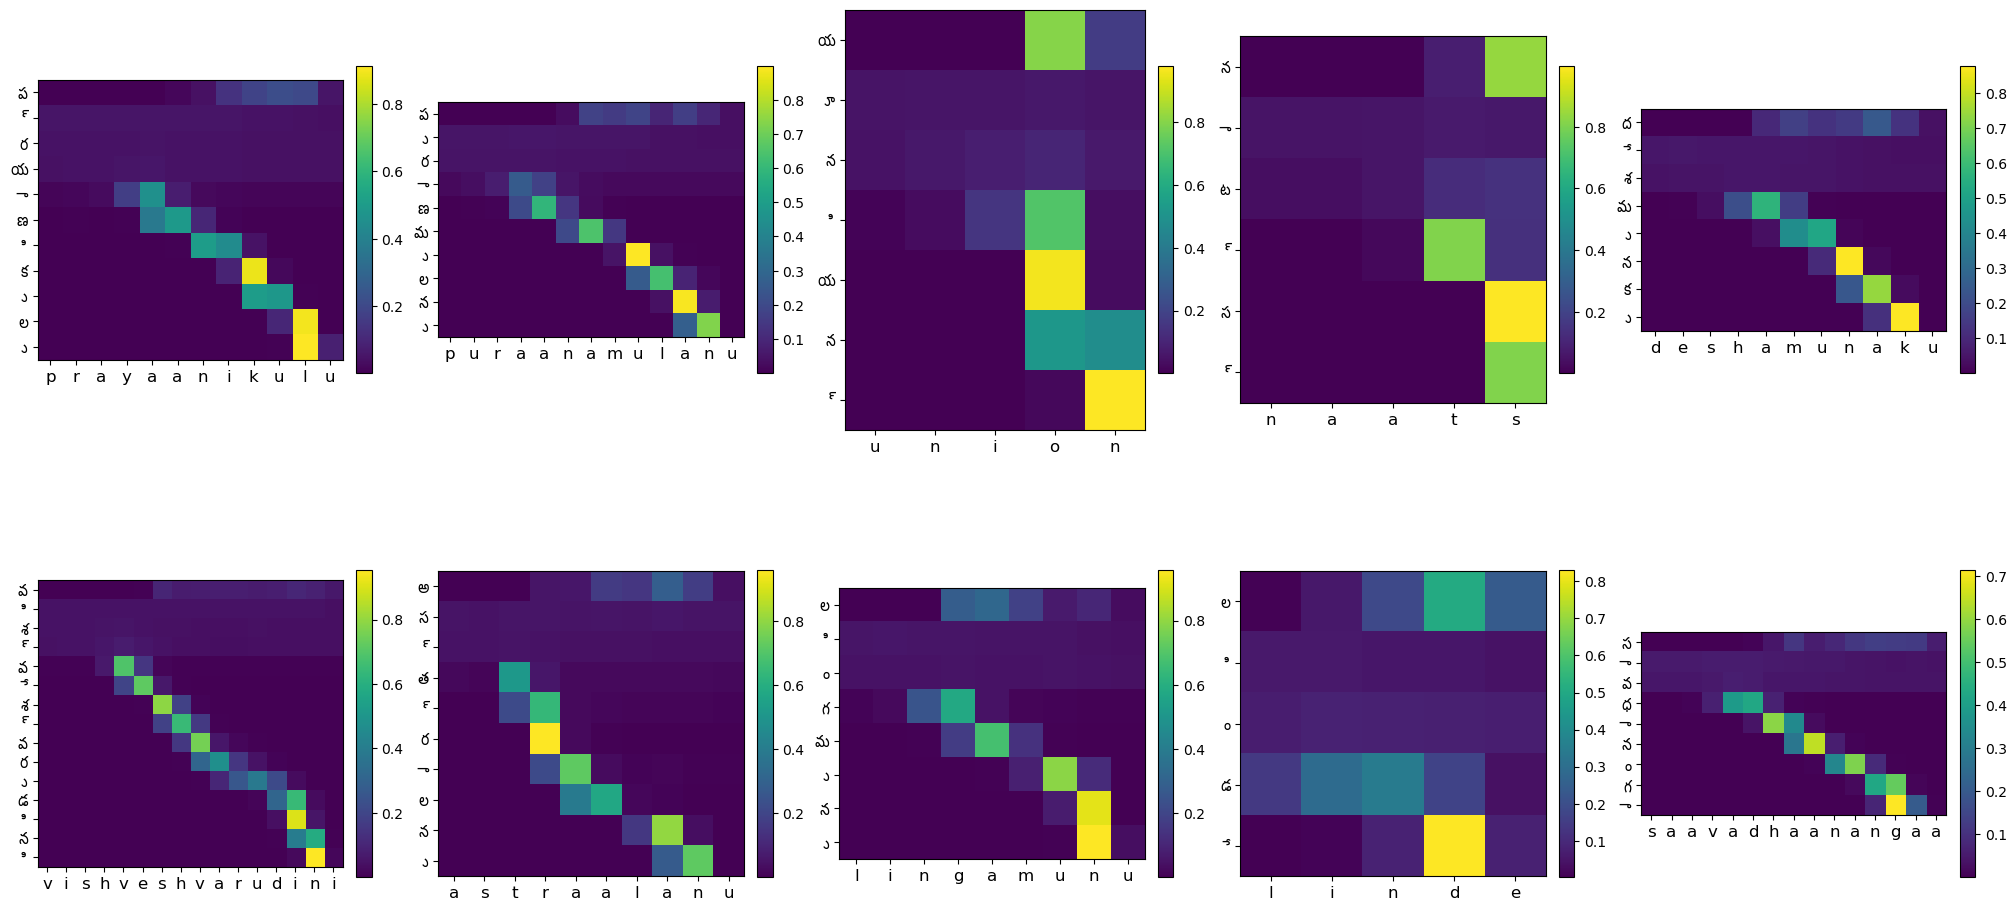

In [328]:
# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(25, 12))

# Plot each heatmap in the grid
for i, ax in enumerate(axes.flat):

    im = ax.imshow(attention_heatmap_data[i][2])
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(attention_heatmap_data[i][0])), labels=attention_heatmap_data[i][0],fontsize=12)
    ax.set_yticks(np.arange(len(attention_heatmap_data[i][1])), labels=list(attention_heatmap_data[i][1]), fontproperties=telugu_font,fontsize=12)

    cbar = ax.figure.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    wandb.log({"Attention-HeatMaps-Visualization": fig})

wandb.finish()
    